# 1 - Importing libraries and initial data cleaning

- Here we import the necessary libraries, mushroom dataset, and we check for missing values in each column.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn import tree


df = pd.read_csv("../../data/mushrooms.csv")


# --- Basic Prescreening ---
print("Shape:", df.shape)
print(df['class'].value_counts())
print("Missing values:", (df == '?').sum())

Shape: (8124, 23)
class
e    4208
p    3916
Name: count, dtype: int64
Missing values: class                          0
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64


** Remarks **

- hmm... seems like a lot of entries are missing for the root column, and since it doeasn't appear crucial to classification we will simply drop the column to preserve data integrity.

In [10]:
df.drop(columns='stalk-root', inplace=True)

# 2 - Visualizing class distribution and by feature

- since the dataset is made up entirely of catagorical variables, the need for preprocessing is minimized. We can go straight to plotting the features to see which are the top predictive features

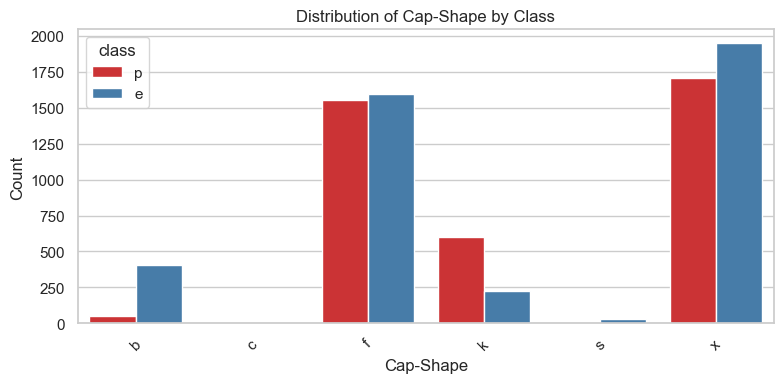

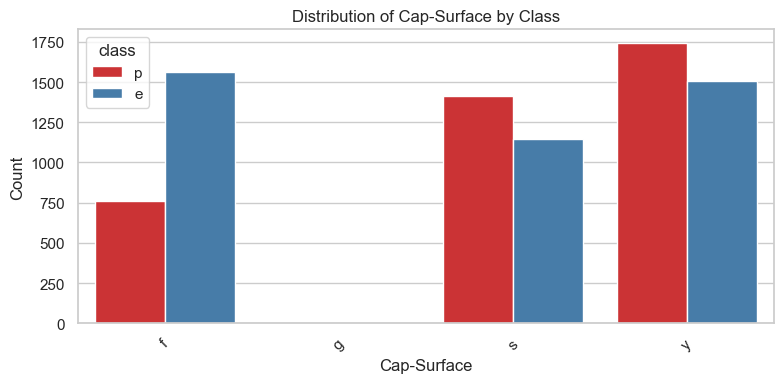

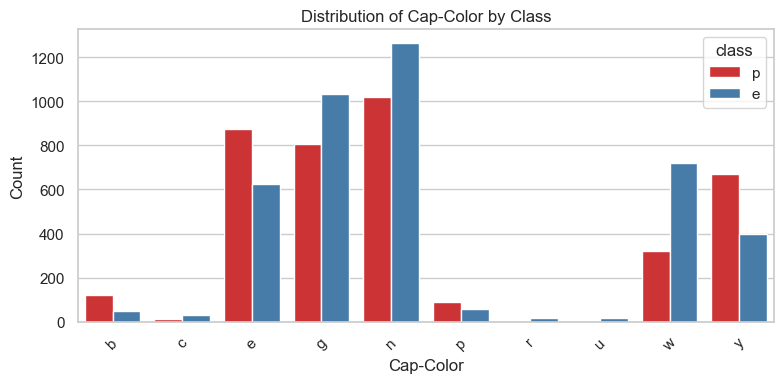

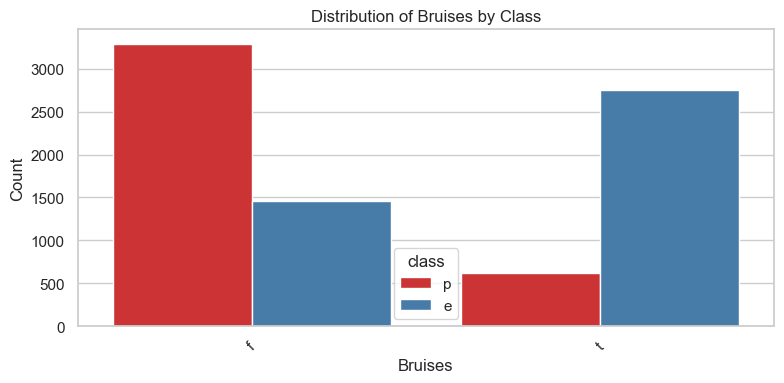

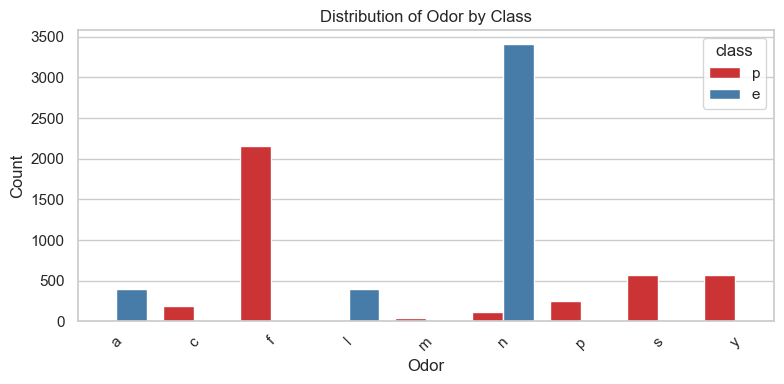

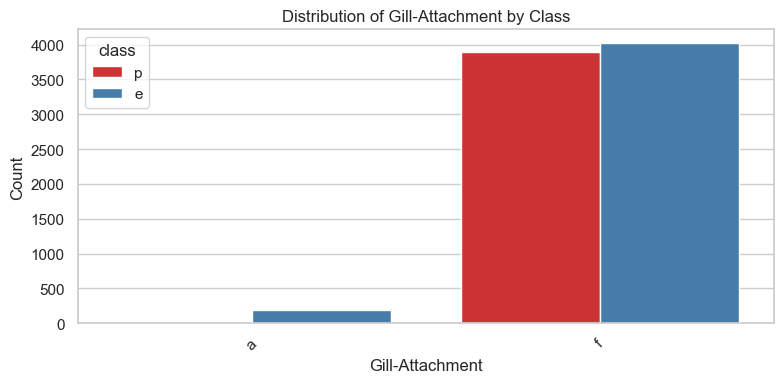

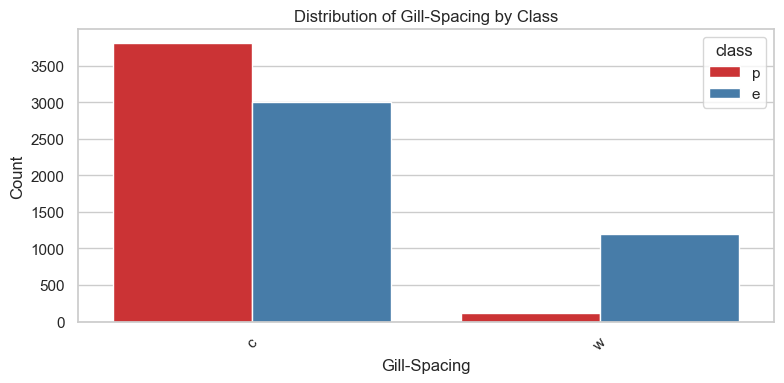

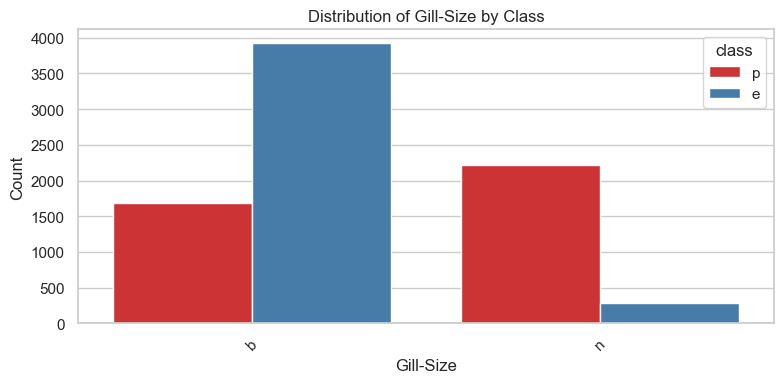

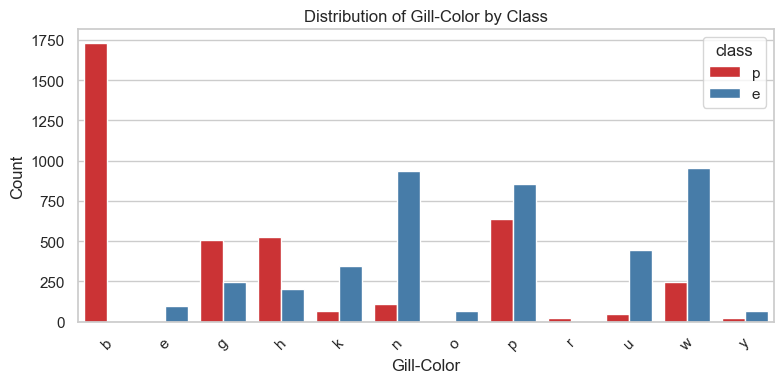

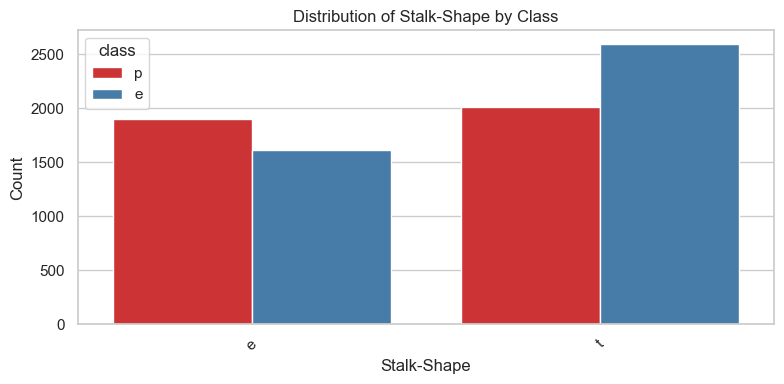

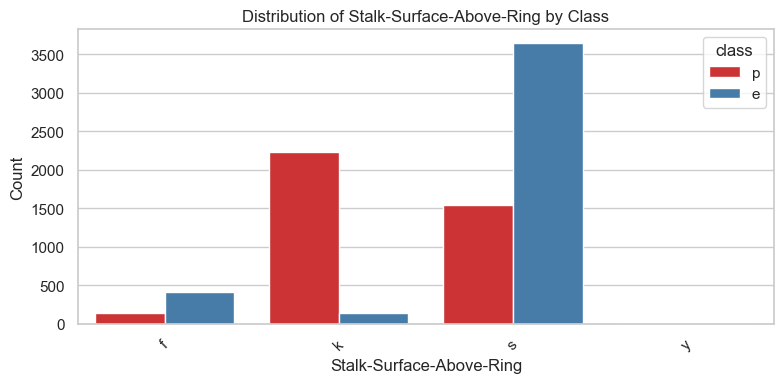

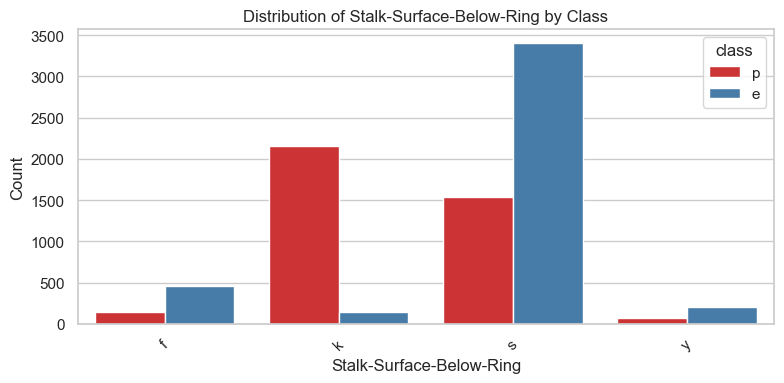

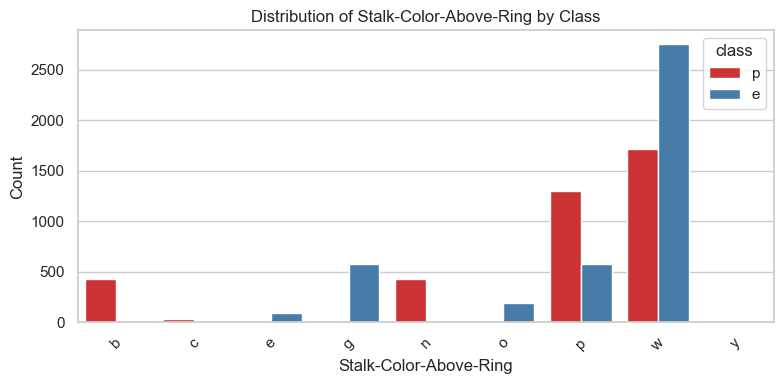

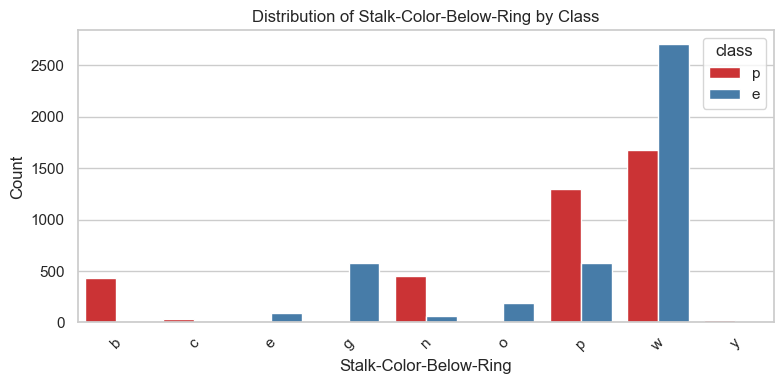

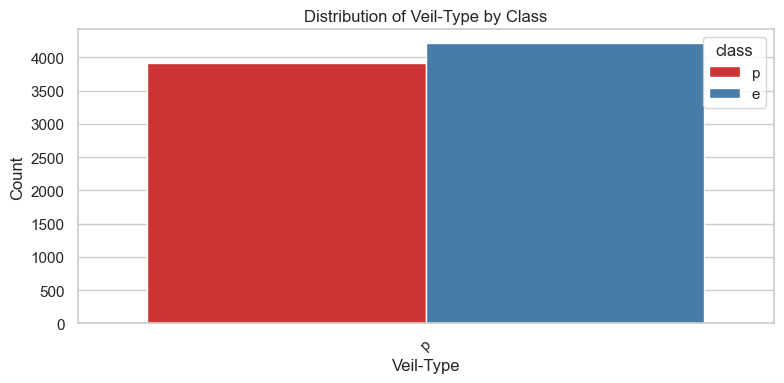

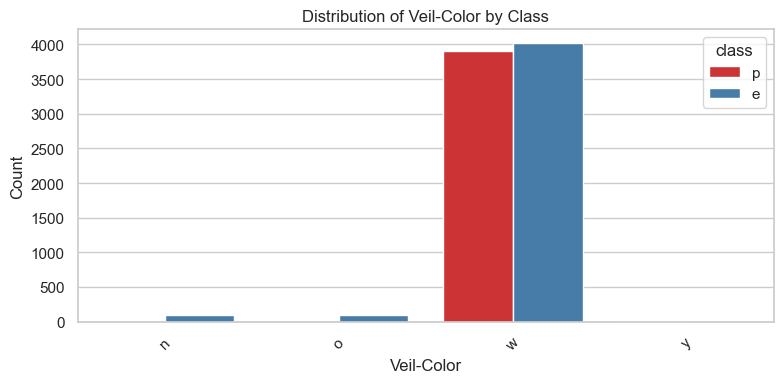

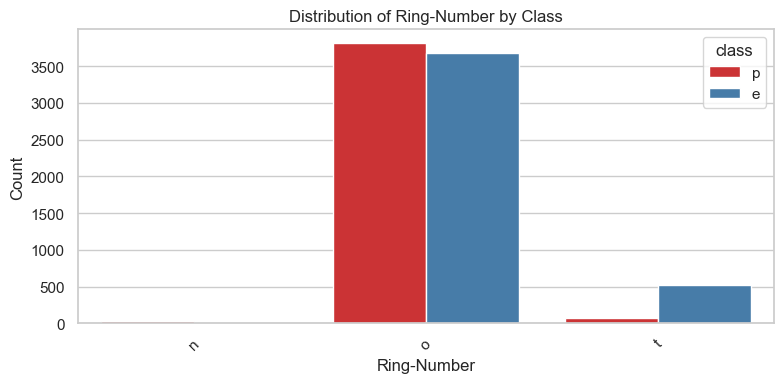

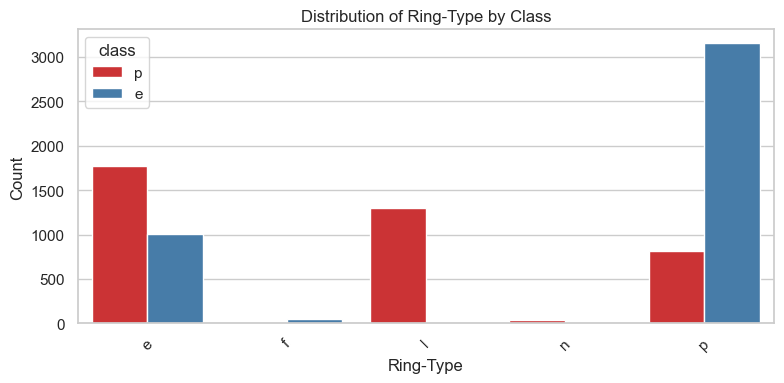

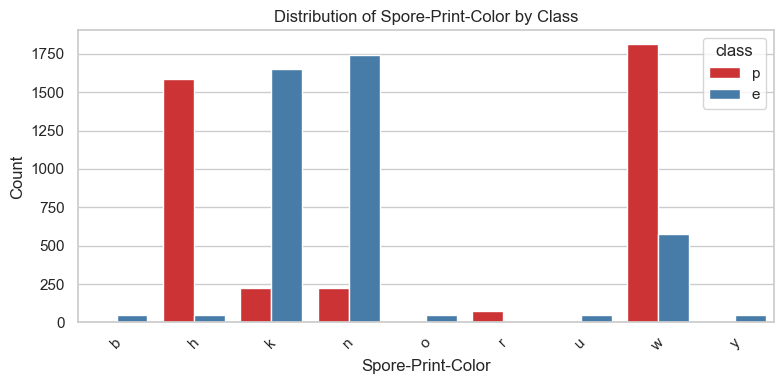

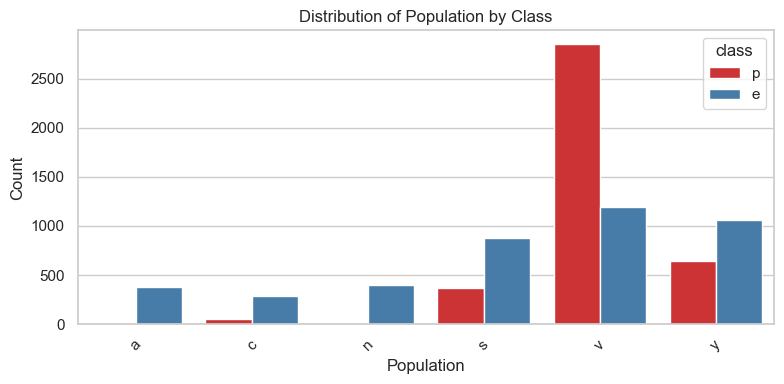

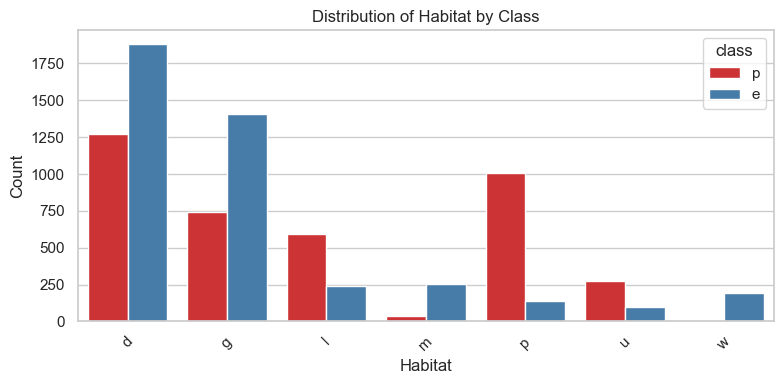

In [13]:
# Set global aesthetics
sns.set(style="whitegrid")

# Get all features except 'class'
features = [col for col in df.columns if col != 'class']

# Plot each feature's distribution grouped by class
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=feature, hue='class', palette='Set1', order=sorted(df[feature].dropna().unique()))
    plt.title(f"Distribution of {feature.title()} by Class")
    plt.xlabel(feature.title())
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


** Remarks **

- from the graphs, we idenify spore print color, ring type, odor, and gill color stand out as strong features for distinguishing between edible and poisonous mushrooms. We will now plot the selected features by themselves

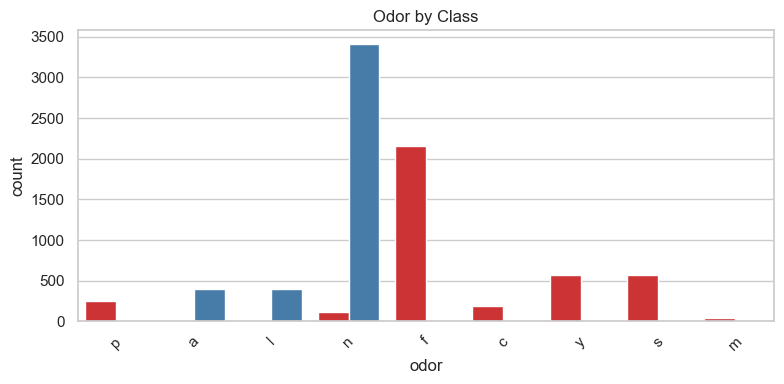

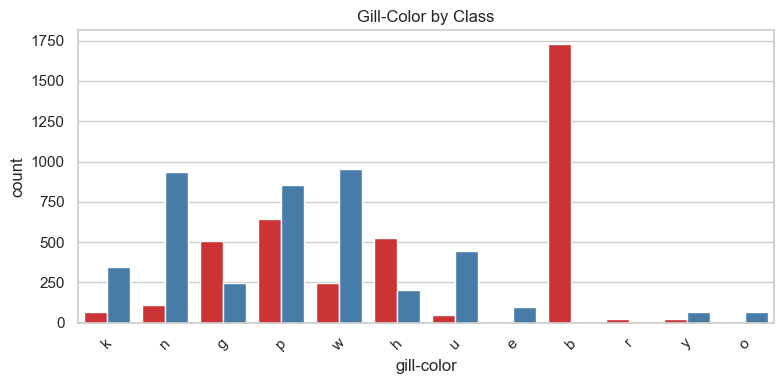

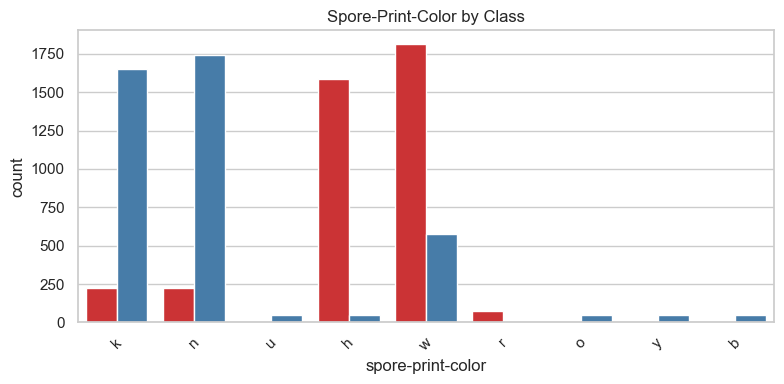

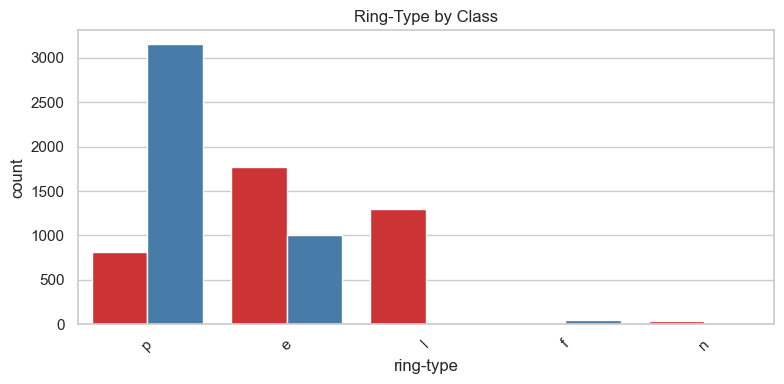

In [14]:
# --- Visualize Feature Distributions (Top Predictive Features) ---
features_to_plot = ['odor', 'gill-color', 'spore-print-color', 'ring-type']

for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=feature, hue='class', legend=False, palette='Set1')
    plt.title(f"{feature.title()} by Class")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

** Remarks **

- Looks like a reasonable set of choices for the attributes. Since no further preprocessing is needed, we will proceed to the Decision Tree implementation.

# 3 - Convert and split data 

- we concert the catagorical variables into numerical valueswith one hot encoding

- We then split the dataset into training and testing.

In [18]:
# Select the most distinguishable features
selected_features = ['spore-print-color', 'ring-type', 'odor', 'gill-color']
X = df[selected_features]
y = df['class']

# One-Hot Encoding for categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, 
                                                    y,
                                                    test_size=0.3, 
                                                    random_state=42)

# 4 - Training the Decision Tree model

- Here we train a decision tree model on our data. for Max Depth, we will start with the arbitrary 5 to see how well it performs

In [26]:
decision_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

# 5 - Printing performance metrics and confusion matrix

In [27]:
print ('decision_tree')
print (metrics.classification_report (y_test, decision_tree.predict (X_test)))

decision_tree
              precision    recall  f1-score   support

           e       0.95      1.00      0.97      1257
           p       1.00      0.94      0.97      1181

    accuracy                           0.97      2438
   macro avg       0.97      0.97      0.97      2438
weighted avg       0.97      0.97      0.97      2438



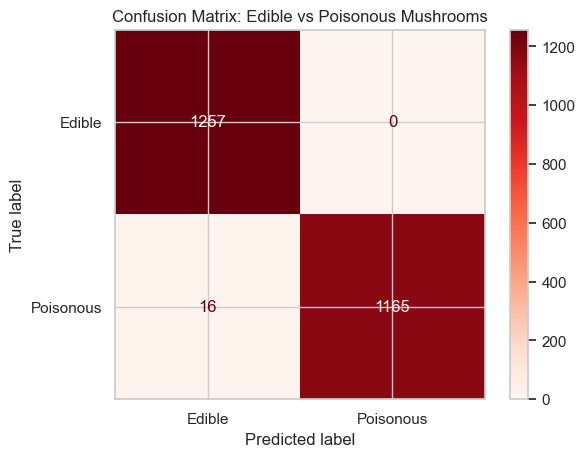

In [31]:
# Initialize and train the DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred = dt_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['e', 'p'])

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Edible', 'Poisonous'])
disp.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix: Edible vs Poisonous Mushrooms")
plt.show()

** Remarks **

- our model achieved 97% accuracy on the mushroom classification task, performing nearly perfectly in distinguishing between edible and poisonous mushrooms, with both precision and recall above 0.94 for each class.

- for Edible Mushrooms ('e'):

    - Precision: 0.95 — 5% of mushrooms predicted edible were actually poisonous.

    - Recall: 1.00 — The model correctly identified all edible mushrooms.

    - F1-score: 0.97

- Poisonous Mushrooms ('p'):

    - Precision: 1.00 — No edible mushrooms were misclassified as poisonous.

    - Recall: 0.94 — About 6% of poisonous mushrooms were misclassified as edible.

    - F1-score: 0.97

- The confusion matrix tells the same story, with our model correctly identifying mushroom vast majority of the times, albiet with a few false negatives.


# 6 - Visualizing the Decision Tree

- we now print out the structure of the tree to see visually how the model is structured.

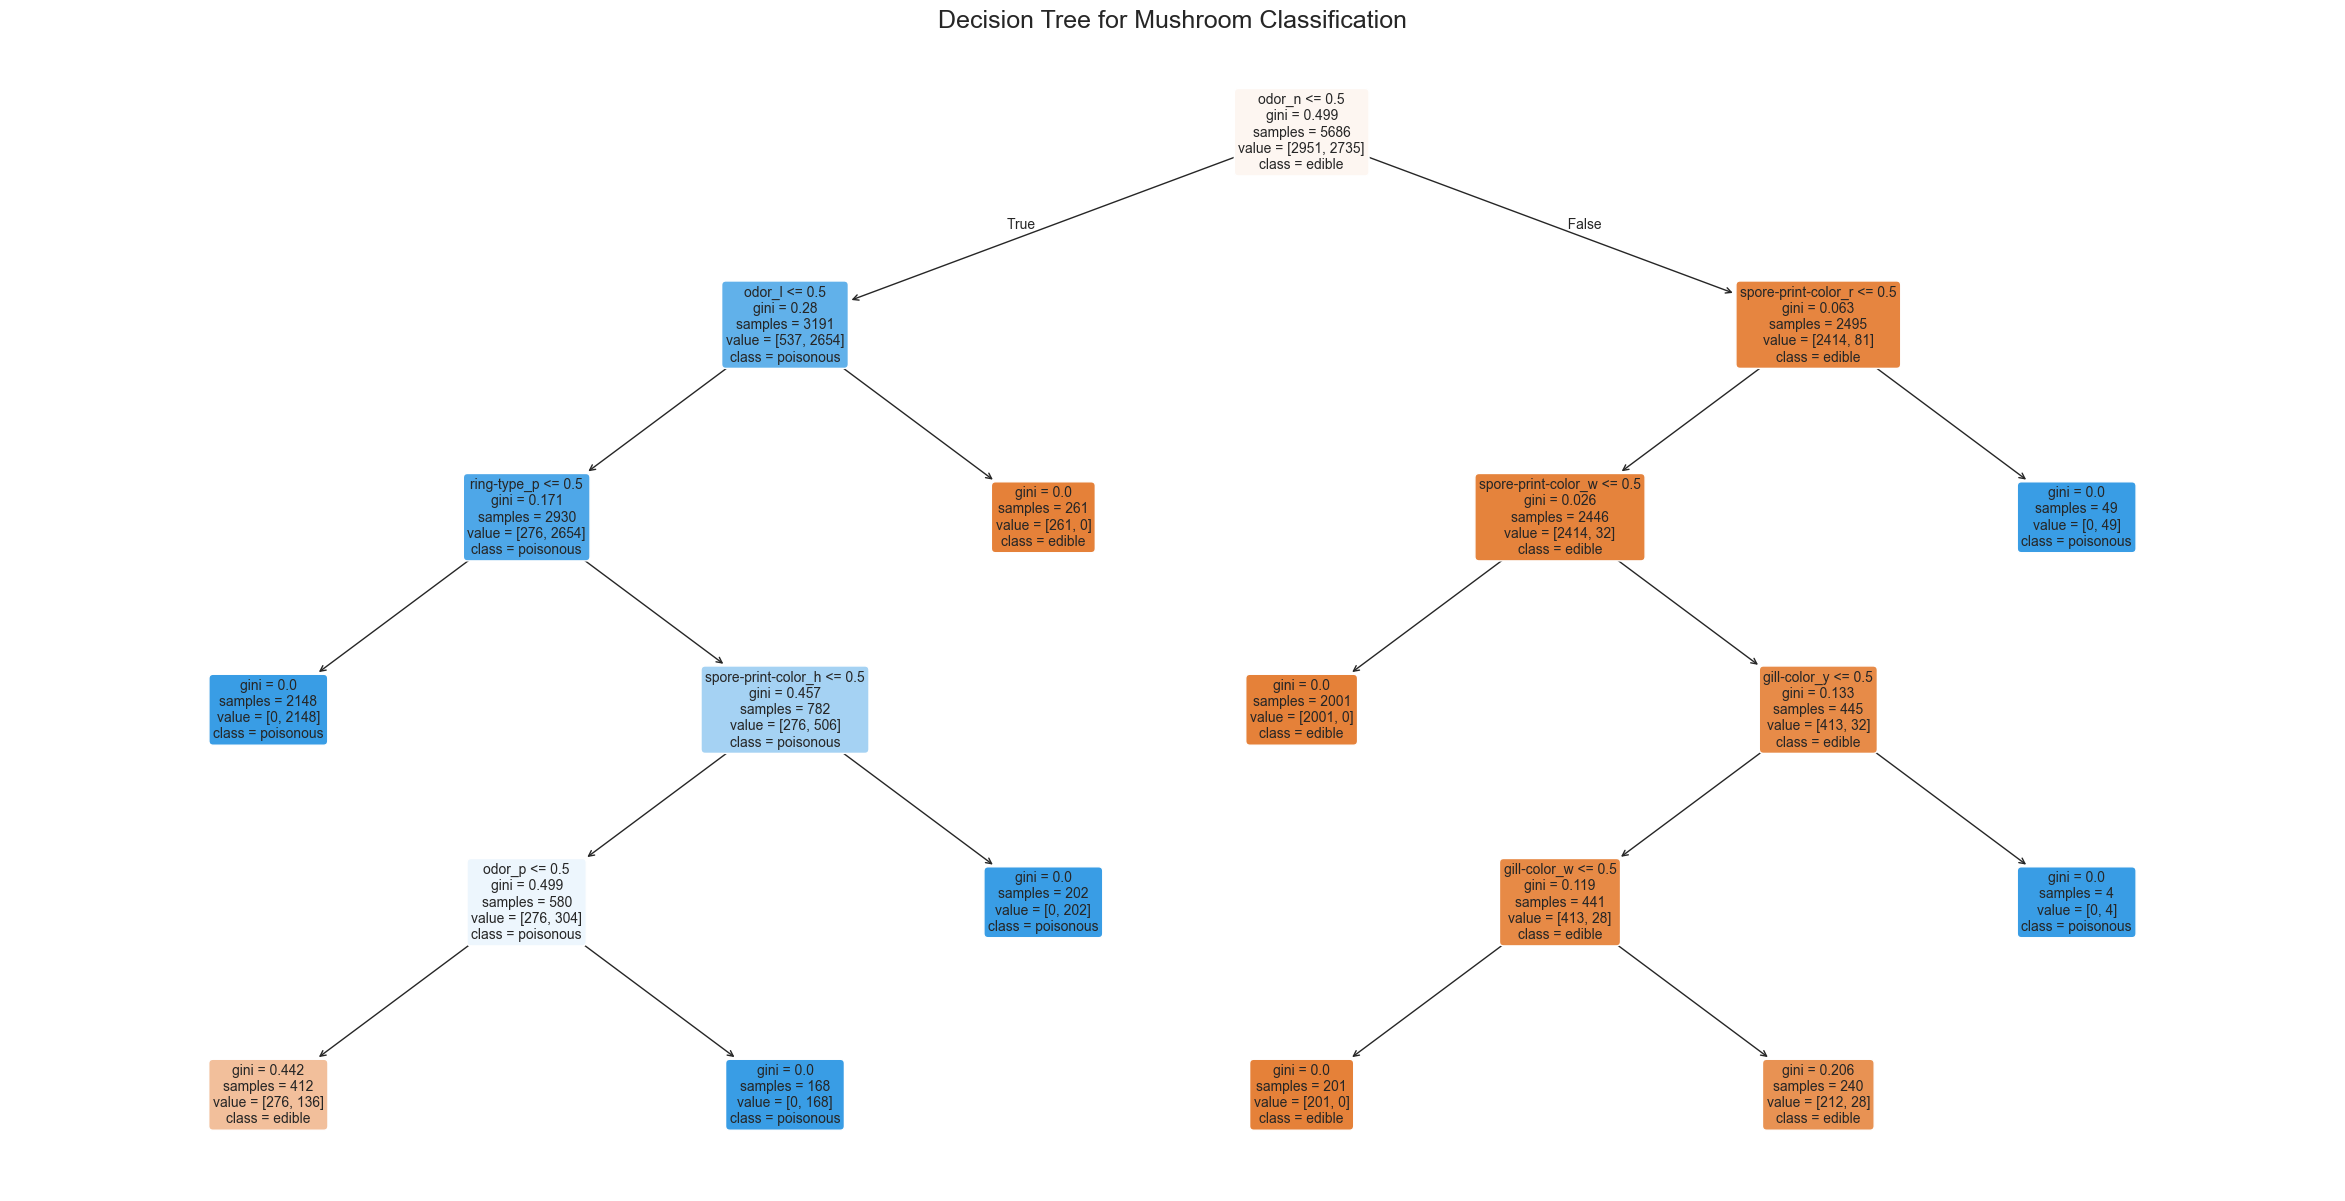

In [35]:
# Plot the decision tree
plt.figure(figsize=(30, 15))
tree.plot_tree(decision_tree, 
               feature_names=X_encoded.columns, 
               class_names=['edible', 'poisonous'], 
               rounded=True, 
               filled=True, 
               fontsize=10)
plt.title("Decision Tree for Mushroom Classification", fontsize=18)
plt.show()

In [36]:
# Export rules from the trained decision tree
features = X_encoded.columns.tolist()  # Make sure to match the encoded feature names
tree_rules = export_text(decision_tree, feature_names=features)

# Print the decision rules
print(tree_rules)

|--- odor_n <= 0.50
|   |--- odor_l <= 0.50
|   |   |--- ring-type_p <= 0.50
|   |   |   |--- class: p
|   |   |--- ring-type_p >  0.50
|   |   |   |--- spore-print-color_h <= 0.50
|   |   |   |   |--- odor_p <= 0.50
|   |   |   |   |   |--- class: e
|   |   |   |   |--- odor_p >  0.50
|   |   |   |   |   |--- class: p
|   |   |   |--- spore-print-color_h >  0.50
|   |   |   |   |--- class: p
|   |--- odor_l >  0.50
|   |   |--- class: e
|--- odor_n >  0.50
|   |--- spore-print-color_r <= 0.50
|   |   |--- spore-print-color_w <= 0.50
|   |   |   |--- class: e
|   |   |--- spore-print-color_w >  0.50
|   |   |   |--- gill-color_y <= 0.50
|   |   |   |   |--- gill-color_w <= 0.50
|   |   |   |   |   |--- class: e
|   |   |   |   |--- gill-color_w >  0.50
|   |   |   |   |   |--- class: e
|   |   |   |--- gill-color_y >  0.50
|   |   |   |   |--- class: p
|   |--- spore-print-color_r >  0.50
|   |   |--- class: p



# 7 - Visualize decision boundary

- Since we used multiple attributes and thus the decision region would be high-dimentional. I will still attempt to plot something by using PCA beforehand to reduce it to a 2D problem. 

- Note tha the decision boundary here is not necessarily the same as it would be for our previous model, since using PCA fundamentally changes the model

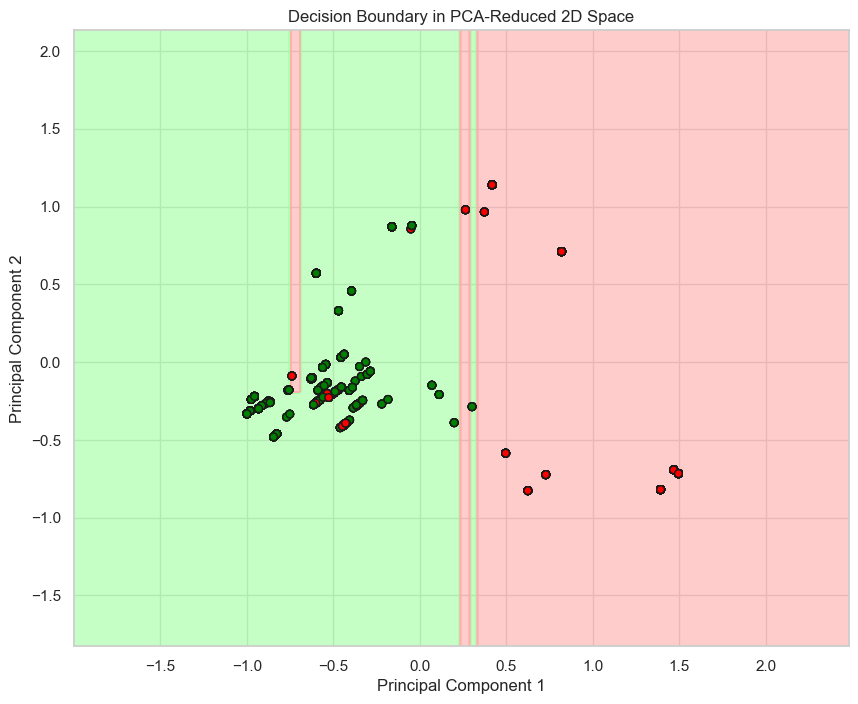

In [38]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# Encode labels as 0 (edible) and 1 (poisonous)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 'e' → 0, 'p' → 1

# PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_encoded)

# Train/test split
X_train_pca, X_test_pca, y_train_enc, y_test_enc = train_test_split(
    X_pca, y_encoded, test_size=0.3, random_state=42
)

# Fit decision tree on PCA data
tree_pca = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_pca.fit(X_train_pca, y_train_enc)

# Plotting decision boundary
plot_step = 0.02
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = tree_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Custom color maps
cmap_light = ListedColormap(["#A0FFA0", "#FFAAAA"])
cmap_bold = ["green", "red"]  # 0: edible, 1: poisonous

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)
plt.scatter(
    X_train_pca[:, 0], X_train_pca[:, 1],
    c=[cmap_bold[i] for i in y_train_enc],
    edgecolor="k", s=30
)
plt.title("Decision Boundary in PCA-Reduced 2D Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


# 8 - Estimating optimal value of max depth

- finally, we note that the max depth was arbitrarily chosen at 5. We will do what we did for K in KNN, and try to find a optimal value for it by iterating it through a range and looking at how the accuracy changes

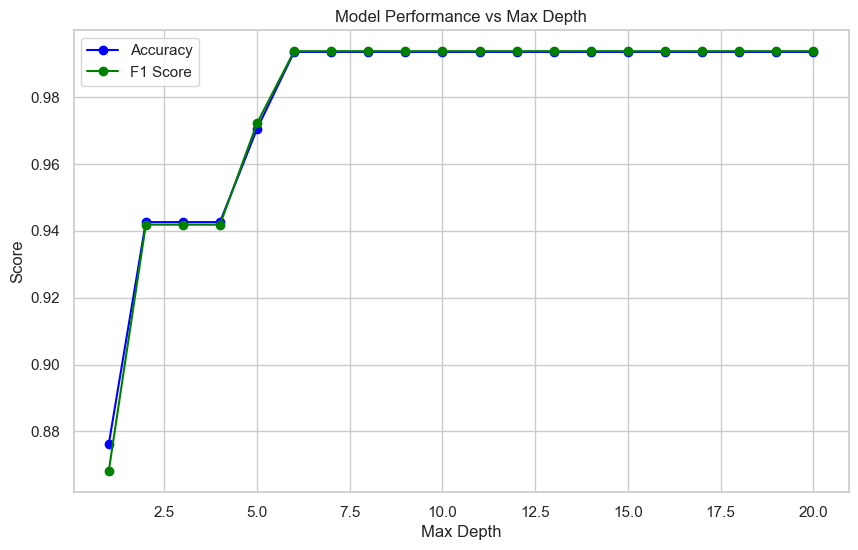

In [43]:
# Initialize lists to store metrics
depth_range = range(1, 21)
accuracy_scores = []
f1_scores = []

# Iterate over different values for max_depth
for depth in depth_range:
    # Initialize the DecisionTreeClassifier with the current max_depth
    dt_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = dt_model.predict(X_test)
    
    # Calculate accuracy and F1 score
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, pos_label='e'))  # F1 for 'e' class (Edible)

# Plot accuracy and F1 scores
plt.figure(figsize=(10, 6))
plt.plot(depth_range, accuracy_scores, label='Accuracy', color='blue', marker='o')
plt.plot(depth_range, f1_scores, label='F1 Score', color='green', marker='o')

plt.title("Model Performance vs Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


** Remarks **

- we can see that both the accuracy and f1 score increased as max depth increased, stablizing after max depth of 6. At that point, it has a over 99% accuracy, which is more than sufficient to be a good model.

# Conclusion - 

- We have seen that the decision tree model is remarkably good at classification based on catagorical datasets such as this one. It was able to achieve 90+ % accuracy with just 2 max depth, eventually reaching more than 99% with 6 max depths. 

- we do note that there are a few false negatives while there are no false positives, which in this context is not good since there is a chance it labels a poisonous mushroom as edible.